In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata

In [2]:
# prepare the data
n_samples = 50000

In [20]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            data.append(np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
            nuisances.append(0.0)
        else:
            #nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            nuisance = np.random.choice(3, 1)[0]
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            nuisances.append(nuisance + 1)
            
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances

In [21]:
data_train, y, nuisances_train = prepare_data(n_samples)

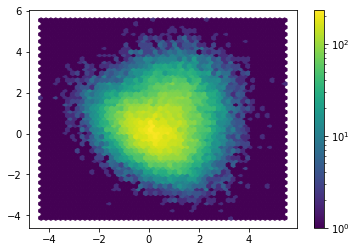

In [5]:
plt.hexbin(x = data_train[:, 0], y = data_train[:, 1], bins = 'log', gridsize = 50)
plt.colorbar()
plt.show()

In [6]:
import tensorflow as tf
ds = tf.contrib.distributions
layers = tf.contrib.layers

In [7]:
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
sess = tf.InteractiveSession(config = config)

In [8]:
data = tf.placeholder(tf.float32, [None, 2], 'data')
labels = tf.placeholder(tf.int64, [None], 'labels')
one_hot_labels = tf.one_hot(labels, 2)
nuisances = tf.placeholder(tf.int64, [None], 'nuisances')
one_hot_nuisances = tf.one_hot(nuisances, 4)

In [9]:
# prepare the models

# the encoder implements p(z|x)
def encoder(data):
    lay = layers.relu(data, 40)
    lay = layers.relu(lay, 40)
    params = layers.linear(lay, 4) # this defines the parameters for the gaussian that produces the encoded output
    mu, sigma = params[:, :2], params[:, 2:]
    encoding = ds.NormalWithSoftplusScale(mu, sigma)
    return encoding

# the decoder implements q(y|z)
def decoder(encoding):
    #lay = layers.fully_connected(encoding, 2, activation_fn = tf.nn.sigmoid)
    lay = layers.linear(encoding, 2)
    return lay

def decoder_nuisance(encoding):
    lay = layers.linear(encoding, 4)
    return lay

In [10]:
prior = ds.Normal(0.0, 1.0)

In [28]:
samplings = 120

# prepare the loss
encoding = encoder(data)
encoding_sampled = encoding.sample(samplings)
decoding = decoder(encoding_sampled)
decoding_single = decoder(encoding.sample())
decoding_nuisance_single = decoder_nuisance(encoding.sample())

one_hot_labels_expanded = tf.expand_dims(one_hot_labels, axis = 0)
one_hot_labels_expanded = tf.tile(one_hot_labels_expanded, [samplings, 1, 1])

#class_loss = tf.reduce_mean(tf.reduce_mean(tf.log(decoding_single), axis = 0))
#class_loss = tf.losses.softmax_cross_entropy(logits = decoding, onehot_labels = one_hot_labels_expanded)
class_loss = tf.losses.softmax_cross_entropy(logits = decoding_single, onehot_labels = one_hot_labels)
nuisance_loss = tf.losses.softmax_cross_entropy(logits = decoding_nuisance_single, onehot_labels = one_hot_nuisances)
info_loss = tf.reduce_sum(tf.reduce_mean(ds.kl_divergence(encoding, prior), axis = 0))

total_loss = class_loss - nuisance_loss#+ 1e-3 * info_loss

In [29]:
# prepare the training
batch_size = 100
steps_per_epoch = int(len(data_train) / batch_size)

In [30]:
global_step = tf.train.get_or_create_global_step()
learning_rate = tf.train.exponential_decay(1e-4, global_step,
                                          decay_steps = 2 * steps_per_epoch,
                                          decay_rate = 0.97, staircase = True)
opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.4)
#opt = tf.train.GradientDescentOptimizer(learning_rate)

ma = tf.train.ExponentialMovingAverage(0.999, zero_debias = True)
ma_update = ma.apply(tf.model_variables())

train_tensor = tf.contrib.training.create_train_op(total_loss, opt,
                                                  global_step, update_ops = [ma_update])

In [31]:
# diagnostics
import math
IZY_bound = math.log(2, 2) - class_loss
IZN_bound = math.log(4, 2) - nuisance_loss
IZX_bound = info_loss

In [32]:
tf.global_variables_initializer().run()

In [33]:
for epoch in range(40):
    for batch in range(steps_per_epoch):
        # get the next batch
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]
        labels_batch = y[inds]
        nuisances_batch = nuisances_train[inds]
        sess.run(train_tensor, feed_dict = {data: data_batch, labels: labels_batch, nuisances: nuisances_batch})
    
    IZY_cur, IZX_cur, IZN_cur = sess.run([IZY_bound, IZX_bound, IZN_bound], feed_dict = {data: data_batch, labels: labels_batch, nuisances: nuisances_batch})
    print("I_ZY = {}\t I_ZN = {}\t I_ZX = {}".format(IZY_cur, IZN_cur, IZX_cur))

I_ZY = 0.34317177534103394	 I_ZN = -2.7914414405822754	 I_ZX = 7.084107398986816
I_ZY = 0.1401503086090088	 I_ZN = -23.553871154785156	 I_ZX = 251.47146606445312
I_ZY = 0.3247928023338318	 I_ZN = -106.30767822265625	 I_ZX = 3188.11767578125
I_ZY = 0.3026731610298157	 I_ZN = -213.4059600830078	 I_ZX = 13038.7744140625
I_ZY = 0.308243989944458	 I_ZN = -465.0848693847656	 I_ZX = 55367.5078125
I_ZY = 0.3021024465560913	 I_ZN = -681.985107421875	 I_ZX = 122337.96875
I_ZY = 0.3500196933746338	 I_ZN = -1140.9093017578125	 I_ZX = 316249.0625
I_ZY = 0.3413364887237549	 I_ZN = -1935.81689453125	 I_ZX = 538069.8125
I_ZY = 0.3711080551147461	 I_ZN = -2392.511962890625	 I_ZX = 1039504.0
I_ZY = 0.3536951541900635	 I_ZN = -3335.023681640625	 I_ZX = 1605323.25
I_ZY = 0.34346938133239746	 I_ZN = -4691.6923828125	 I_ZX = 2459052.0
I_ZY = 0.3133915066719055	 I_ZN = -5390.6279296875	 I_ZX = 4076177.5
I_ZY = 0.35038864612579346	 I_ZN = -6431.30517578125	 I_ZX = 6446200.0
I_ZY = 0.3531619906425476	 I_ZN = -

In [34]:
# prepare test data
data_test = np.random.uniform(low = -1, high = 2, size = [50000, 2])

In [35]:
pred = sess.run(decoding, feed_dict = {data: data_test})

In [36]:
pred_mean = np.mean(pred, axis = 0)
pred_std = np.std(pred, axis = 0)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
/home/philipp/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'interp'
  s)


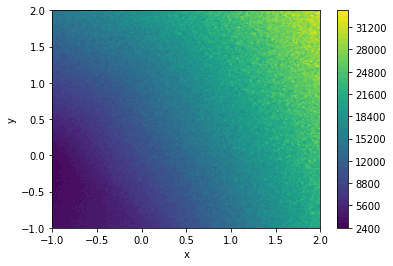

In [37]:
# plot a contour map
xi = np.linspace(-1, 2, 1000)
yi = np.linspace(-1, 2, 1000)
zi = griddata(data_test[:, 0], data_test[:, 1], pred_mean[:, 0], xi, yi, interp = "linear")

plt.contourf(xi, yi, zi, interp='linear', levels = 50)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

/usr/lib/python3/dist-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
/home/philipp/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'interp'
  s)


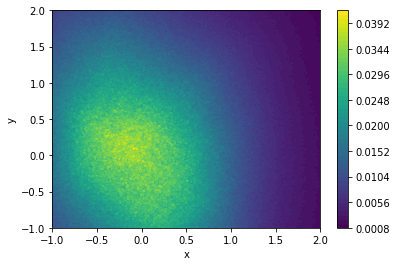

In [27]:
# plot a contour map
xi = np.linspace(-1, 2, 1000)
yi = np.linspace(-1, 2, 1000)
zi = griddata(data_test[:, 0], data_test[:, 1], pred_std[:, 0], xi, yi, interp = "linear")

plt.contourf(xi, yi, zi, interp='linear', levels = 50)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [198]:
sess.close()